I trained all the models on Kaggle and hence the file paths are according to them. If running locally, replace them with the commented one beside them (they are fixed in beginning of the code only).<br> Also change for the test dataset accordingly

In [37]:
# Importing required libraries

import numpy as np
import os
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import issparse
from PIL import Image

In [38]:
# Configurations & Reproducibility

data_path = '/kaggle/input/tabular-data/' # '../data/processed/'
image_dir = '/kaggle/input/imagery-train/' # '../data/images/train/images/'
save_model_dir = '/kaggle/working/' # '/model_output/'

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [40]:
# LOADING DATA
print("Loading data...")

if os.path.exists(f'{data_path}X_train.npy'):
    X_train = np.load(f'{data_path}X_train.npy', allow_pickle=True)
    y_train = np.load(f'{data_path}y_train.npy', allow_pickle=True)
    train_ids = np.load(f'{data_path}train_ids.npy', allow_pickle=True)
    X_val = np.load(f'{data_path}X_val.npy', allow_pickle=True)
    y_val = np.load(f'{data_path}y_val.npy', allow_pickle=True)
    val_ids = np.load(f'{data_path}val_ids.npy', allow_pickle=True)

    # Handle Sparse/Wrapped Inputs
    if X_train.shape == (): X_train = X_train.item()
    if X_val.shape == (): X_val = X_val.item()
    if issparse(X_train): X_train = X_train.toarray().astype(np.float32)
    else: X_train = np.array(X_train, dtype=np.float32)
    if issparse(X_val): X_val = X_val.toarray().astype(np.float32)
    else: X_val = np.array(X_val, dtype=np.float32)

    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)
    print(f"Data Loaded. Train: {X_train.shape}, Val: {X_val.shape}")
else:
    raise FileNotFoundError("Please run the preprocessing script to generate .npy files first.")


Loading data...
Data Loaded. Train: (12888, 64), Val: (3222, 64)


In [39]:
# DATASET CLASS
class ViTMultimodalDataset(Dataset):
    def __init__(self, X_tabular, y_labels, property_ids, image_dir, transform=None):
        self.X_tabular = torch.FloatTensor(X_tabular)
        self.y_labels = torch.FloatTensor(y_labels)
        self.property_ids = property_ids
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.property_ids)

    def __getitem__(self, idx):
        img_id = self.property_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.png")
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0)) # Black fallback

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'tabular': self.X_tabular[idx],
            'label': self.y_labels[idx]
        }

# ViT FUSION MODEL ARCHITECTURE
class ViTFusionModel(nn.Module):
    def __init__(self, tabular_dim):
        super(ViTFusionModel, self).__init__()

        # 1. Vision Branch: Pre-trained ViT-B/16
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

        self.vit.heads = nn.Identity()

        # Freeze ViT initially
        for param in self.vit.parameters():
            param.requires_grad = False

        # 2. Tabular Branch
        self.tabular_mlp = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # 3. Fusion Head (768 from ViT + 128 from Tabular)
        self.fusion = nn.Sequential(
            nn.Linear(768 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1) # Output: Log Price
        )

        # Initialize final bias to mean log-price (around 13.0) for stability
        nn.init.constant_(self.fusion[-1].bias, 13.0)

    def forward(self, img, tab):
        # ViT Output: [Batch, 768] (CLS Token representation)
        img_emb = self.vit(img)

        # Tabular Output: [Batch, 128]
        tab_emb = self.tabular_mlp(tab)

        # Concatenate
        combined = torch.cat((img_emb, tab_emb), dim=1)

        return self.fusion(combined).squeeze(-1)


In [41]:
# ViT standard transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ViTMultimodalDataset(X_train, y_train, train_ids, image_dir, transform)
val_dataset = ViTMultimodalDataset(X_val, y_val, val_ids, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# TRAINING LOOP
model = ViTFusionModel(tabular_dim=X_train.shape[1]).to(device)

# Using AdamW for Transformers
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
criterion = nn.MSELoss()

epochs = 15
best_rmse = float('inf')
unfreeze_epoch = 8

print("Starting ViT Training...")

for epoch in range(epochs):

    if epoch == unfreeze_epoch:
        print("\nUnfreezing ViT Encoder for fine-tuning...")
        for param in model.vit.parameters():
            param.requires_grad = True
        for g in optimizer.param_groups:
            g['lr'] = 1e-5

    model.train()
    train_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for batch in pbar:
        img = batch['image'].to(device)
        tab = batch['tabular'].to(device)
        label = batch['label'].to(device)

        optimizer.zero_grad()
        output = model(img, tab)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            img = batch['image'].to(device)
            tab = batch['tabular'].to(device)
            output = model(img, tab)
            val_preds.extend(output.cpu().numpy())
            val_labels.extend(batch['label'].cpu().numpy())

    val_rmse = np.sqrt(mean_squared_error(val_labels, val_preds))
    val_r2 = r2_score(val_labels, val_preds)

    print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f} | Val RMSE: {val_rmse:.4f} | Val R2: {val_r2:.4f}")

    scheduler.step(val_rmse)

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        torch.save(model.state_dict(), f'{save_model_dir}best_vit_model.pth')
        print(f"  Saved Best ViT Model (RMSE: {best_rmse:.4f})")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 209MB/s]  


Starting ViT Training...


Epoch 1 | Train Loss: 0.0759 | Val RMSE: 0.2129 | Val R2: 0.8329
  Saved Best ViT Model (RMSE: 0.2129)


Epoch 2 | Train Loss: 0.0513 | Val RMSE: 0.1979 | Val R2: 0.8556
  Saved Best ViT Model (RMSE: 0.1979)


Epoch 3 | Train Loss: 0.0502 | Val RMSE: 0.1987 | Val R2: 0.8545


Epoch 4 | Train Loss: 0.0466 | Val RMSE: 0.2381 | Val R2: 0.7910


Epoch 5 | Train Loss: 0.0474 | Val RMSE: 0.2120 | Val R2: 0.8343


Epoch 6 | Train Loss: 0.0393 | Val RMSE: 0.1866 | Val R2: 0.8717
  Saved Best ViT Model (RMSE: 0.1866)


Epoch 7 | Train Loss: 0.0372 | Val RMSE: 0.1815 | Val R2: 0.8785
  Saved Best ViT Model (RMSE: 0.1815)


Epoch 8 | Train Loss: 0.0363 | Val RMSE: 0.1837 | Val R2: 0.8756

Unfreezing ViT Encoder for fine-tuning...


Epoch 9 | Train Loss: 0.0395 | Val RMSE: 0.1798 | Val R2: 0.8808
  Saved Best ViT Model (RMSE: 0.1798)


Epoch 10 | Train Loss: 0.0337 | Val RMSE: 0.1838 | Val R2: 0.8754


Epoch 11 | Train Loss: 0.0288 | Val RMSE: 0.1840 | Val R2: 0.8752


Epoch 12 | Train Loss: 0.0245 | Val RMSE: 0.1933 | Val R2: 0.8623


Epoch 13 | Train Loss: 0.0190 | Val RMSE: 0.1840 | Val R2: 0.8752


Epoch 14 | Train Loss: 0.0176 | Val RMSE: 0.1844 | Val R2: 0.8746


Epoch 15 | Train Loss: 0.0169 | Val RMSE: 0.1864 | Val R2: 0.8719


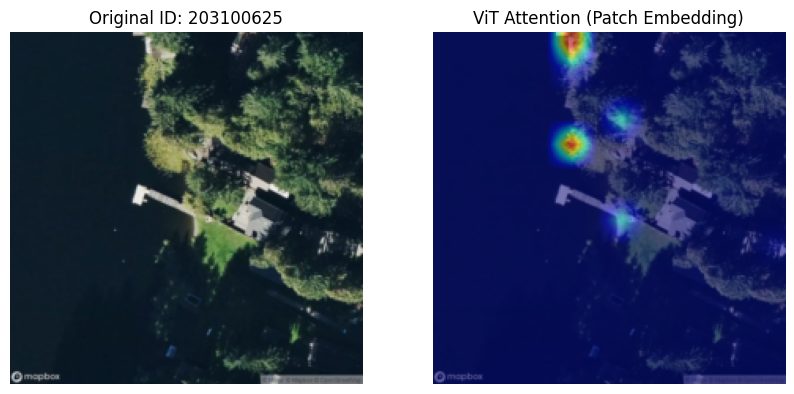

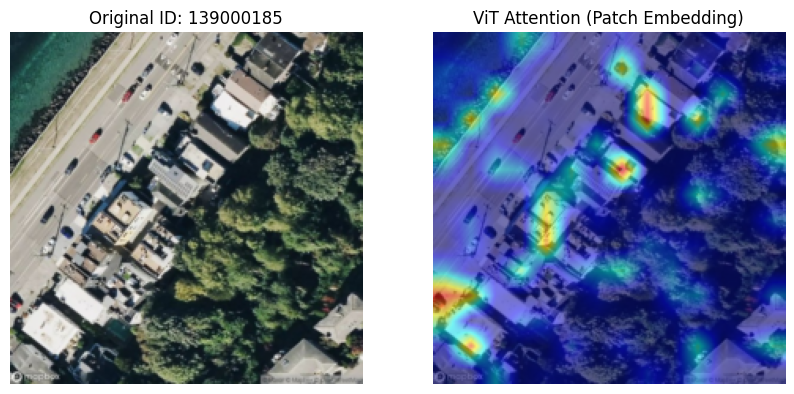

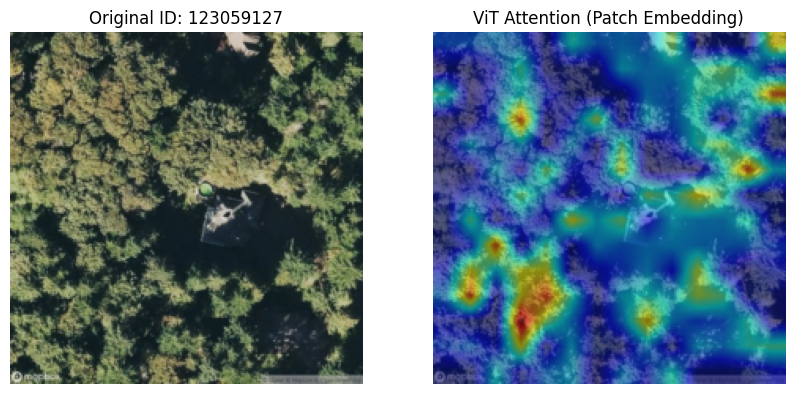

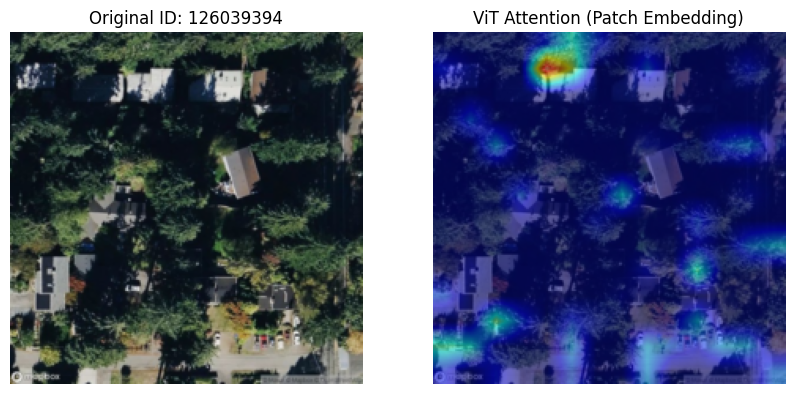

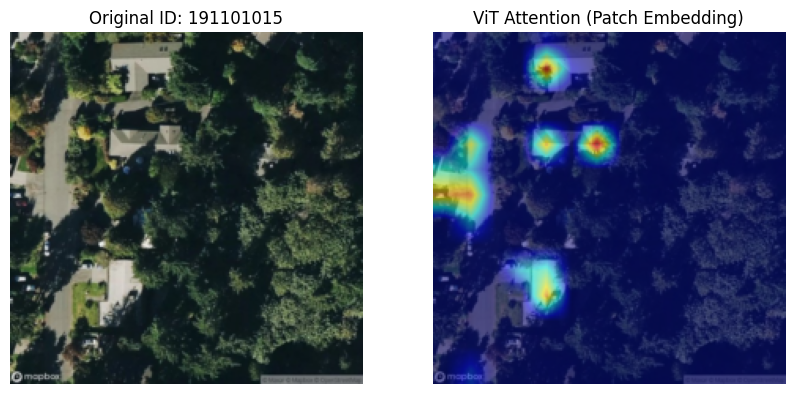

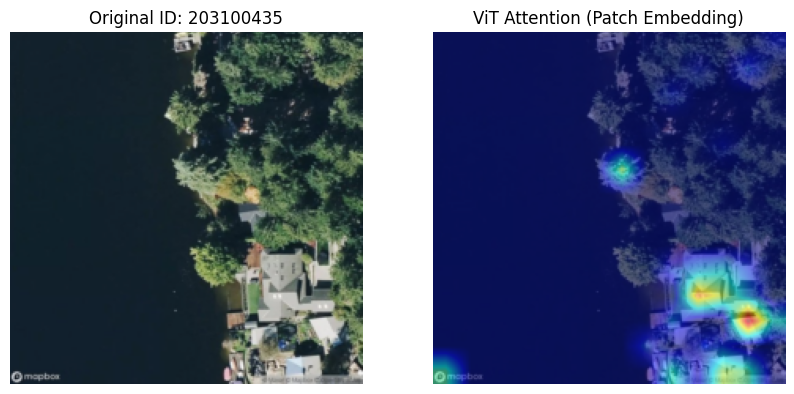

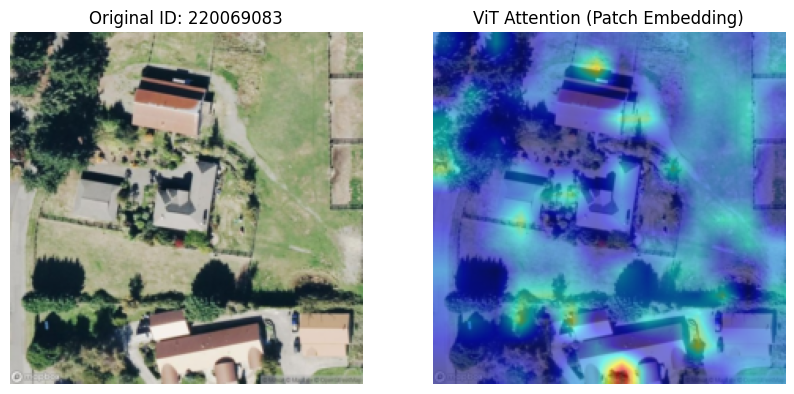

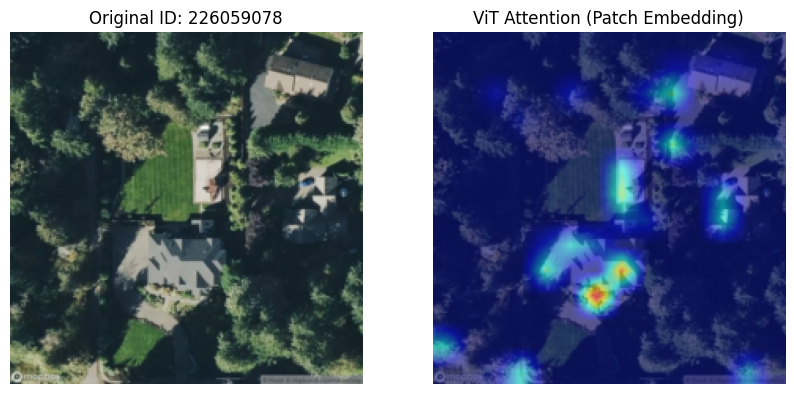

In [46]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

def generate_vit_gradcam_robust(model, image_tensor, tabular_tensor, device):

    # Robust Grad-CAM for ViT by targeting the initial Patch Embedding Conv Layer.
    model.eval()

    target_layer = model.vit.conv_proj

    gradients = []
    activations = []

    def save_gradient(grad):
        gradients.append(grad)

    def save_activation(module, input, output):
        activations.append(output)

    # Register hooks
    handle_grad = target_layer.register_full_backward_hook(lambda m, i, o: save_gradient(o[0]))
    handle_act = target_layer.register_forward_hook(save_activation)

    # Forward Pass
    image_tensor = image_tensor.to(device).unsqueeze(0)
    tabular_tensor = tabular_tensor.to(device).unsqueeze(0)
    image_tensor.requires_grad = True

    output = model(image_tensor, tabular_tensor)

    # Backward Pass
    model.zero_grad()
    output.backward()

    # Get Data
    # Shape is [1, 768, 14, 14] -> Standard CNN shape
    grad = gradients[0].cpu().data.numpy()[0]
    act = activations[0].cpu().data.numpy()[0]

    # Global Average Pooling on Gradients
    weights = np.mean(grad, axis=(1, 2))

    # Create Heatmap
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i, :, :]

    # ReLU
    cam = np.maximum(cam, 0)

    # Normalize
    if np.max(cam) != 0:
        cam = cam / np.max(cam)
    else:
        print("Warning: Zero gradients found. Scaling raw activation.")
        cam = np.mean(act, axis=0)
        cam = np.maximum(cam, 0)
        cam = cam / (np.max(cam) + 1e-8)

    cam = cv2.resize(cam, (224, 224))

    # Cleanup
    handle_grad.remove()
    handle_act.remove()

    return cam

def plot_vit_results(model, dataset, property_id, device):

    try:
        idx = list(dataset.property_ids).index(property_id)
    except ValueError:
        return

    data = dataset[idx]
    img_tensor = data['image']
    tab_tensor = data['tabular']

    # Denormalize
    original_img = img_tensor.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    original_img = std * original_img + mean
    original_img = np.clip(original_img, 0, 1)

    # Generate Heatmap
    heatmap = generate_vit_gradcam_robust(model, img_tensor, tab_tensor, device)

    # Visualization
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0

    superimposed = heatmap_colored * 0.5 + original_img * 0.5

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_img)
    ax[0].set_title(f"Original ID: {property_id}")
    ax[0].axis('off')

    ax[1].imshow(superimposed)
    ax[1].set_title("ViT Attention (Patch Embedding)")
    ax[1].axis('off')

    plt.savefig(f"VIT_{property_id}.png", bbox_inches='tight', dpi=300)
    plt.show()

# Run it
model.load_state_dict(torch.load(f'{save_model_dir}best_vit_model.pth'))
model.to(device)

sample_ids = [139000185, 123059127, 126039394, 191101015, 203100435, 203100625, 220069083, 226059078]
for pid in sample_ids:
    plot_vit_results(model, val_dataset, pid, device)
for pid in sample_ids:
    plot_vit_results(model, train_dataset, pid, device)

The Vision Transformer (ViT) architecture tokenizes satellite imagery into discrete 16x16 pixel patches, resulting in a characteristic grid-like attention pattern that highlights how the model weighs specific land features. The visualizations show that the model excels at detecting geometric boundaries and global textures, such as the sharp contrast of a shoreline or the specific density of a residential block, to infer property value. By processing these visual tokens independently, the ViT can identify high-value proxies like waterfront access or detractive features like commercial pavement across the entire image.